# Random Forest Classification

Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', 200)
root = "../../"

Creating a df with the disease rates for each city and their respective RISK value (1, if it belongs to a high risk cluster, and 0 otherwise).

In [3]:
risk_df = pd.read_csv(root + 'CSV/SatScan/muncod_risk.csv', index_col=0)
path = root + 'CSV/TabNet/Rates/'
all_files = glob.glob(path + "*.csv")

for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("_RATE")[0]
    disease_df = pd.read_csv(path + file_name, sep=',', index_col=0)
    
    columns = disease_df.columns.drop("MUNCOD")
    disease_df[disease] = disease_df[columns].mean(1)
    
    disease_df = disease_df[[disease, "MUNCOD"]]
    risk_df = pd.merge(disease_df, risk_df, left_on="MUNCOD", right_on="MUNCOD", how="right") 

df = risk_df
disease_columns = list(df.columns.drop(["RISK", "MUNCOD"]))
df = df.dropna(how='all', subset=disease_columns)
df = df.fillna(0)
df.head()

,TRAUMATISMO_INTRACRANIANO,MUNCOD,TRANSTORNOS_MENTAIS,TECIDO_MOLE,OSTEOPOROSE,INSUFICIENCIA_RENAL,INSUFICIENCIA_CARDIACA,HIV,HIPERTENSAO,ESCLEROSE_MULTIPLA,EPILEPSIA,ENXAQUECA,DPOC,DORSOPATIAS,DOENCA_DE_PARKINSON,DOENCA_CARDIACA,DIABETES_MELLITUS,CANCER,ASMA,RISK
0,105.731433,110001,34.604426,16.621795,5.469222,15.791199,177.816460,1.466140,428.103843,0.709813,37.834737,3.298005,385.917988,18.821112,0.355419,74.325566,184.736069,125.289498,303.875964,1
1,66.123620,110002,36.464982,12.344312,11.021169,50.423154,167.764367,14.534894,26.120704,0.192123,26.287200,4.952137,73.145339,19.984579,0.000000,56.194194,105.525021,114.327271,58.588967,1
2,113.578497,110003,27.279379,9.002957,7.497109,43.754732,167.879795,1.671738,109.509757,0.000000,31.395815,1.445525,80.301640,14.590501,1.357865,109.655031,254.636374,114.317634,29.547299,1
3,82.554600,110004,22.045603,12.134021,8.779860,94.641465,167.985637,4.042561,146.366408,0.000000,65.227597,3.390436,74.543344,25.662765,1.180118,85.891932,167.430757,211.231986,56.326570,1
4,119.919410,110005,21.958809,8.341679,2.090679,63.117664,315.066326,4.771815,114.310736,0.506909,43.367614,0.000000,178.717537,17.485356,1.089526,98.729665,228.036514,124.281673,266.223389,1


Here we create a dictionary where each key-value pair (k,v) indicates that v rows have k values equal to 0. 

In [4]:
from collections import Counter
l = list(df[disease_columns].apply(lambda x: x.eq(0)).sum(axis=1))
c=Counter(l)
c

Counter({0: 971,
         1: 1096,
         3: 1160,
         2: 1537,
         4: 512,
         5: 195,
         6: 68,
         8: 8,
         10: 1,
         7: 16})

## Training the Dataset

Selecting X (independent variables) and y (dependent binary variable).

In [5]:
import numpy as np

X = df.drop(columns =['MUNCOD', 'RISK'])
y = df["RISK"]

print("Number of entries:", X.shape[0])
print("Number of features:", X.shape[1])

Number of entries: 5564
Number of features: 18


Number of 0 values for each column

In [6]:
df.drop(columns =['MUNCOD', 'RISK']).apply(lambda x: x.eq(0).sum())

TRAUMATISMO_INTRACRANIANO       0
TRANSTORNOS_MENTAIS            20
TECIDO_MOLE                   128
OSTEOPOROSE                   253
INSUFICIENCIA_RENAL             8
INSUFICIENCIA_CARDIACA          0
HIV                          1416
HIPERTENSAO                   102
ESCLEROSE_MULTIPLA           3393
EPILEPSIA                      35
ENXAQUECA                    1546
DPOC                            9
DORSOPATIAS                   507
DOENCA_DE_PARKINSON          3827
DOENCA_CARDIACA                 2
DIABETES_MELLITUS               1
CANCER                          0
ASMA                           20
dtype: int64

Splitting the dataset into the Training set and Test set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

Fitting Random Forest to the Training set

In [8]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
model = classifier.fit(X_train, y_train)

## Making predictions

Predicting the Test set results

In [9]:
y_pred = classifier.predict(X_test)

Making the Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1145,  242],
       [ 339, 1056]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

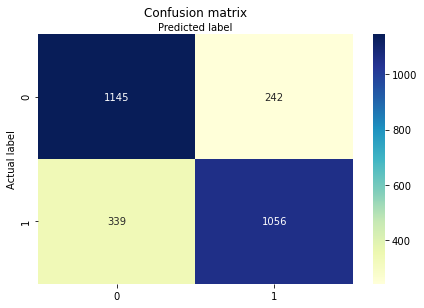

In [11]:
class_names = [0, 1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Checking Evaluation metrics

In [12]:
from sklearn import metrics
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("FBeta:",metrics.fbeta_score(y_test, y_pred, beta=2.0))

Precision: 0.8135593220338984
Recall: 0.7569892473118279
FBeta: 0.7676650189008433


Plotting the ROC curve

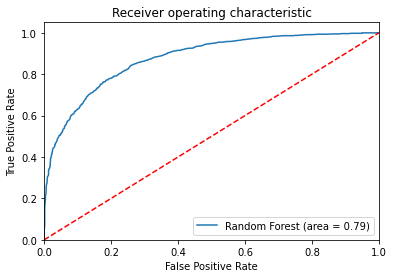

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.rc("font", size=10)
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## K-fold cross Validation

Load libraries

In [14]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

Define X and y

In [15]:
X = df.drop(columns =['MUNCOD', 'RISK'])
y = df["RISK"]

Create a pipeline that standardizes, then runs random forest

In [16]:
random = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
pipeline = make_pipeline(random)

Do k-fold cross-validation

In [17]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(pipeline, # Pipeline
                             X, # Feature matrix
                             y, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="f1", # Loss function
                             n_jobs=-1) # Use all CPU scores

(array([1., 3., 2., 3., 0., 0., 0., 0., 0., 1.]),
 array([0.77224199, 0.77908084, 0.78591969, 0.79275854, 0.79959738,
        0.80643623, 0.81327508, 0.82011393, 0.82695278, 0.83379162,
        0.84063047]),
 <a list of 10 Patch objects>)

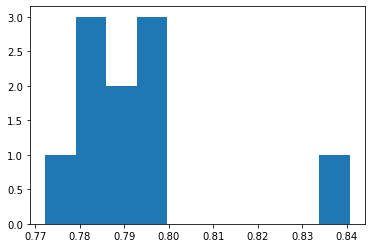

In [18]:
plt.hist(x=cv_results, bins=10)

Calculate Mean Performance Score

In [19]:
cv_results.mean()

0.7919631384397181

# SHAP

## One-city analysis
SHAP analysis for the city of São Paulo (MUNCOD = 355030) 

In [20]:
X_sp = df.loc[df['MUNCOD'] == 355030].drop(columns=["MUNCOD", "RISK"])
y_sp = df.loc[df['MUNCOD'] == 355030]["RISK"]

print("Is SP in a high risk cluster?", y_sp.values[0] == 1)
X_sp

Is SP in a high risk cluster? False


,TRAUMATISMO_INTRACRANIANO,TRANSTORNOS_MENTAIS,TECIDO_MOLE,OSTEOPOROSE,INSUFICIENCIA_RENAL,INSUFICIENCIA_CARDIACA,HIV,HIPERTENSAO,ESCLEROSE_MULTIPLA,EPILEPSIA,ENXAQUECA,DPOC,DORSOPATIAS,DOENCA_DE_PARKINSON,DOENCA_CARDIACA,DIABETES_MELLITUS,CANCER,ASMA
3827,73.050766,150.135185,15.354554,7.941776,41.445787,84.63275,22.438626,32.823142,2.735263,30.875803,2.618765,29.398847,5.90402,0.520024,139.68071,40.620246,229.417738,38.330562


In [21]:
data_for_prediction = X_sp.iloc[0]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
data_for_prediction

TRAUMATISMO_INTRACRANIANO     73.050766
TRANSTORNOS_MENTAIS          150.135185
TECIDO_MOLE                   15.354554
OSTEOPOROSE                    7.941776
INSUFICIENCIA_RENAL           41.445787
INSUFICIENCIA_CARDIACA        84.632750
HIV                           22.438626
HIPERTENSAO                   32.823142
ESCLEROSE_MULTIPLA             2.735263
EPILEPSIA                     30.875803
ENXAQUECA                      2.618765
DPOC                          29.398847
DORSOPATIAS                    5.904020
DOENCA_DE_PARKINSON            0.520024
DOENCA_CARDIACA              139.680710
DIABETES_MELLITUS             40.620246
CANCER                       229.417738
ASMA                          38.330562
Name: 3827, dtype: float64

We will use a TreeExplainer

In [22]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

## Global analysis

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


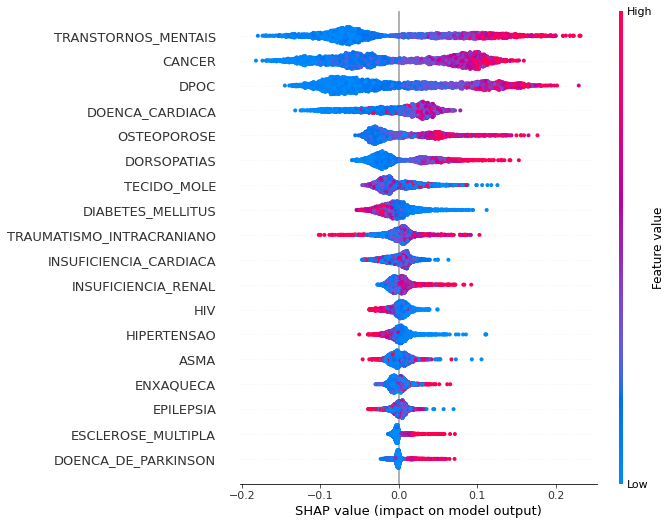

In [24]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)